# A simple regression model using Keras with Cloud TPUs

This notebook demonstrates using Cloud TPUs in colab to build a simple regression model using **y = sin(x)** to predict y for given x.

**Advantages:**
*   GCP account is not compulsory which is a must pre-requisite for the models using TPUEstimator()
*   Generated huge amount of data to compare the training performance on TPU vs CPU.

###Imports

In [0]:
#  Copyright 2018 The TensorFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,0
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
"""An Example of a Regression model using Keras for the y = sin(x) dataset."""

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import math
import os
import pprint
import matplotlib.pyplot as plt

from sklearn import metrics

In [0]:
print(tf.__version__)

1.12.0-rc2


###Resolve TPU Address

In [0]:
use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

with tf.Session(TF_MASTER) as session:
  print ('List of devices:')
  pprint.pprint(session.list_devices())

List of devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 3204130715220914658),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1757131222346187914),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 14189073471542166552),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 18089629823860601296),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3346547477748453737),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 6512962655626301676),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 1886142505182871901),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 49656553673112525),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 1173330136390527977),
 _DeviceAttributes(/jo

### Creating data for y = sin(x).
Sine wave data is created using numpy. And to make it more difficult, random noice is added to the sine wave.

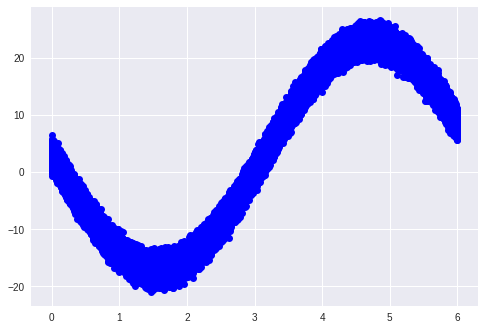

In [0]:
data_size = 2**18

x = np.linspace(0, 6, data_size)
np.random.shuffle(x)

y = -20 * np.sin(x) + 3 + np.random.normal(0, 1, (data_size,))

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

train_x, test_x = x[:data_size/2], x[data_size/2:]
train_y, test_y = y[:data_size/2], y[data_size/2:]

plt.plot(x, y, 'bo')

###Define model:
Model will have an input layer where it takes in the x coordinate, two densely connected layers with 200 and 80 nodes, and an output layer where it returns the predicted y value.

In [0]:
def get_model():
  return keras.Sequential([
      keras.layers.Dense(1, input_shape=(1,)),
      keras.layers.Dense(200, activation=tf.nn.sigmoid),
      keras.layers.Dense(80, activation=tf.nn.sigmoid),
      keras.layers.Dense(1)
  ])

In [0]:
model = get_model()
model.compile(optimizer=tf.train.GradientDescentOptimizer(.01),
             loss='mean_squared_error',
             metrics=['mean_squared_error'])

###Creating a TPU model from a Keras Model
To make the model usable by a TPU, converting it using keras_to_tpu_model.

In [0]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TF_MASTER)))

INFO:tensorflow:Querying Tensorflow master (grpc://10.63.218.106:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3204130715220914658)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1757131222346187914)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 14189073471542166552)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 18089629823860601296)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3346547477748453737)
INFO:tensorflow:*** Available Device: _DeviceAt

###Training of the model on TPU

In [0]:
tpu_model.fit(train_x, train_y, epochs=10, steps_per_epoch=512)
tpu_model.save_weights('/tmp/sine.h5', overwrite=True)

Epoch 1/10
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16384,), dtype=tf.int32, name=u'core_id0'), TensorSpec(shape=(16384, 1), dtype=tf.float32, name=u'dense_4_input_10'), TensorSpec(shape=(16384, 1), dtype=tf.float32, name=u'dense_7_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for dense_4_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 18.0318541527 secs
INFO:tensorflow:Setting weights on TPU model.
512/512 [==============================] - 33s 65ms/step - loss: 38.1645 - mean_squared_error: 38.1645
Epoch 2/10
512/512 [==============================] - 14s 26ms/step - loss: 8.4381 - mean_squared_error: 8.4381
Epoch 3/10
512/512 [==============================] - 14s 26ms/step - loss: 7.3682 - mean_squared_error: 7.3682
Epoch 4/10
512/512 [==============================] - 13s 26ms/step - loss: 7.3235 - mean_squared_error: 7.3235
Epoch 5/

###Prediction
For predictions, same model architecture is being used which is loaded with the earlier learned weights.

In [0]:
prediction_model = get_model()
prediction_model.load_weights('/tmp/sine.h5')

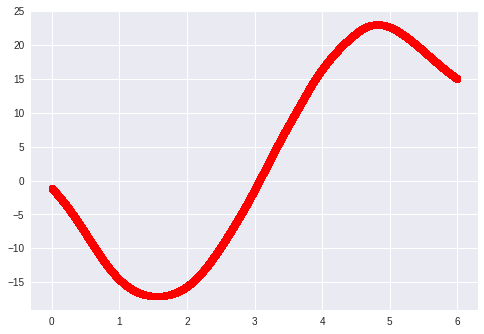

In [0]:
predictions = prediction_model.predict(test_x)
plt.plot(test_x, predictions, 'ro')

###Training on CPU for comparison with TPU
How much time did we save by using a TPU? Let's try training the exact same model on the same data, but without the TPU speedup.

**(WARNING: This will take a long time to execute!)**

In [0]:
slow_model = get_model()
slow_model.compile(optimizer=tf.train.GradientDescentOptimizer(.01),
             loss='mean_squared_error',
             metrics=['mean_squared_error'])
slow_model.fit(train_x, train_y, epochs=10, steps_per_epoch=512)

Epoch 1/10
512/512 [==============================] - 45s 88ms/step - loss: 40.1559 - mean_squared_error: 40.1559
Epoch 2/10
512/512 [==============================] - 44s 87ms/step - loss: 8.6203 - mean_squared_error: 8.6203
Epoch 3/10
512/512 [==============================] - 44s 86ms/step - loss: 7.5388 - mean_squared_error: 7.5388
Epoch 4/10
512/512 [==============================] - 44s 85ms/step - loss: 7.3395 - mean_squared_error: 7.3395
Epoch 5/10
512/512 [==============================] - 44s 86ms/step - loss: 6.3310 - mean_squared_error: 6.3310
Epoch 6/10
512/512 [==============================] - 44s 87ms/step - loss: 5.3646 - mean_squared_error: 5.3646
Epoch 7/10
512/512 [==============================] - 45s 88ms/step - loss: 4.9005 - mean_squared_error: 4.9005
Epoch 8/10
512/512 [==============================] - 44s 86ms/step - loss: 4.5581 - mean_squared_error: 4.5581
Epoch 9/10
512/512 [==============================] - 44s 87ms/step - loss: 4.2622 - mean_squared_erro